In [2]:
pip install tensorflow==2.17.1



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow as tf

print(tf.__version__)

2.17.1


In [14]:
import mlflow
import keras
import numpy as np
import matplotlib.pyplot as plt
from mlflow import MlflowClient

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from mlflow.models.signature import infer_signature
import sagemaker
from sagemaker import get_execution_role
# from sagemaker import Session
from sagemaker.tensorflow import TensorFlow
# from sagemaker.sklearn.estimator import SKLearn

import boto3
import pandas as pd
import os

In [16]:
# Define session, role, and region so we can
# perform any SageMaker tasks we need
# sagemaker_session = sagemaker.Session()
# role = get_execution_role()
# region = sagemaker_session.boto_region_name


In [17]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [18]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [19]:
class_names = [
    'T-shirt/top', 
    'Trouser', 
    'Pullover', 
    'Dress', 
    'Coat',
    'Sandal', 
    'Shirt', 
    'Sneaker', 
    'Bag', 
    'Ankle boot'
]

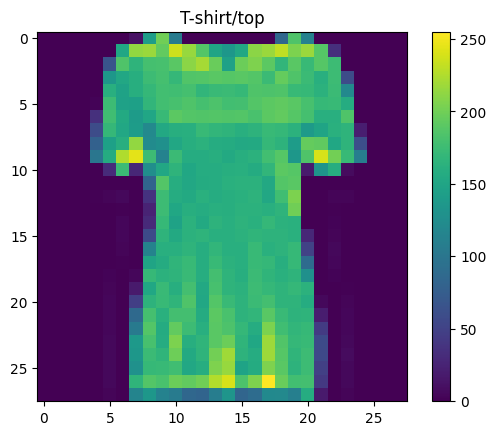

In [20]:
# visualize unnormalised raw image
plt.figure()

plt.imshow(train_images[10])
plt.colorbar()
plt.title(class_names[train_labels[10]])

plt.show()

Images are normalised and a set is plotted

In [21]:
train_images = train_images / 255.0

test_images = test_images / 255.0

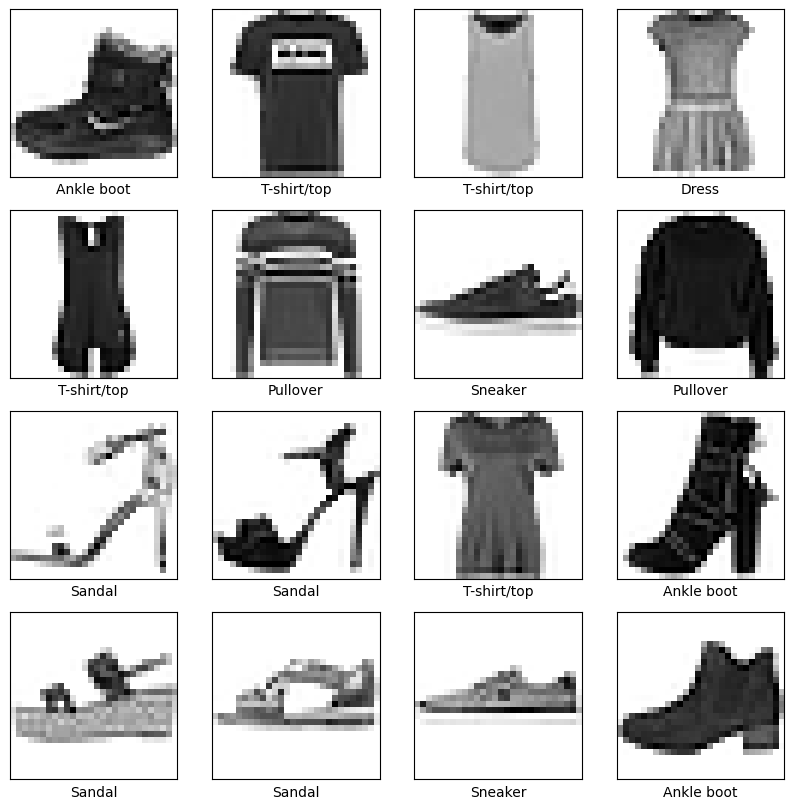

In [22]:
plt.figure(figsize = (10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    
    plt.xlabel(class_names[train_labels[i]])

plt.show()

In [23]:
train_images[2]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.08627451,
        0.4627451 , 0.09411765, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.18823529, 0.34509804, 0.01960784,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.04705882, 0.39215686,
        0.83137255, 0.80392157, 0.7254902 , 0.70196078, 0.67843137,
        0.72941176, 0.75686275, 0.86666667, 0.55686275, 0.33333333,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.29803922, 0.78039216, 0.88235294, 0.97254902, 1.        ,
        0.93333333, 0.8862

### Creating 'Fashion_images_prediction' experiment in MLflow

In [24]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

mlflow.set_experiment('fashion_images_pred')

<Experiment: artifact_location='/Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/CLOUD/AI/projects/mlflow/dl-mlfow/mlruns', creation_time=1746460315181, experiment_id='179252477911319809', last_update_time=1746460315181, lifecycle_stage='active', name='fashion_images_pred', tags={}>

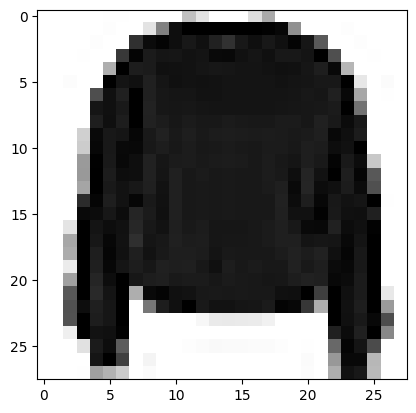

In [25]:
fig1 = plt.imshow(train_images[7], cmap = plt.cm.binary)

**Same image converted to an Image object using PIL**

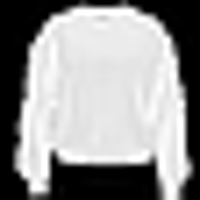

In [26]:
from PIL import Image

im = Image.fromarray(np.uint8(train_images[7] * 255)).resize((200, 200))

im

In [27]:
# log 30 images but the images will be overwritten if they have the same label. 
# using 30 is to ensure that we have images of a number of different classes
with mlflow.start_run():
    for i in range(100, 130):
        mlflow.log_image(
            Image.fromarray(np.uint8(train_images[i] * 255)).resize((200, 200)) , 
            f"{class_names[train_labels[i]]}.png"
        )

🏃 View run merciful-fish-216 at: http://127.0.0.1:5000/#/experiments/179252477911319809/runs/0719ee03514d4140ac5d98c062694d24
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/179252477911319809


**Train model and Autolog**

In [28]:
# autolog model parameters, disable models log so that model signature and model is explicitly logged
mlflow.tensorflow.autolog(log_models = False)

with mlflow.start_run() as tf_run:
    
    # batch_size, height, width, n_channels
    X_train = train_images.reshape((train_images.shape[0], 28, 28, 1))
    X_test = test_images.reshape((test_images.shape[0], 28, 28, 1))
    
    y_train = to_categorical(train_labels)
    y_test = to_categorical(test_labels)
    
    # input_example shape (1, 28, 28, 1)
    # add dimention with expand_dims
    input_example = np.expand_dims(X_train[0], axis = 0)
    
    model = Sequential()
    
    # Convolutional + pooling layer with 32 filters = depth of 32 output
    model.add(
        Conv2D(
            32, kernel_size = (3, 3),
            activation = 'relu', 
            kernel_initializer = 'he_normal', # to converge faster
            input_shape = (28, 28, 1)
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25)) # turns off neuron to prevent overfitting
    
    # Convolution + pooling layer
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # Convolution + pooling layer
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(Dropout(0.4))

    # Linear layer
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.3))
    
    # Softmax to output class probabilities
    model.add(Dense(10, activation = 'softmax')) 

    model.compile(
        loss = keras.losses.categorical_crossentropy, 
        optimizer = keras.optimizers.Adam(),
        metrics = ['accuracy']
    )
    
    model.fit(X_train, y_train,
              epochs = 10, batch_size = 32, 
              validation_data = (X_test, y_test))

    signature = infer_signature(X_test, model.predict(X_test))
    
    mlflow.tensorflow.log_model(
        model, 'fashion_mnist_cnn', 
        signature = signature, 
        input_example = input_example
    )

/Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/CLOUD/AI/projects/mlflow/mlflow_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7092 - loss: 0.7915

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7092 - loss: 0.7913 - val_accuracy: 0.8623 - val_loss: 0.3767
Epoch 2/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8500 - loss: 0.4051

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8501 - loss: 0.4050 - val_accuracy: 0.8829 - val_loss: 0.3205
Epoch 3/10
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8757 - loss: 0.3425

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8757 - loss: 0.3425 - val_accuracy: 0.8906 - val_loss: 0.2988
Epoch 4/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8795 - loss: 0.3271

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8795 - loss: 0.3271 - val_accuracy: 0.8979 - val_loss: 0.2780
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8872 - loss: 0.3047 - val_accuracy: 0.8810 - val_loss: 0.3209
Epoch 6/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8904 - loss: 0.2985

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8904 - loss: 0.2985 - val_accuracy: 0.8980 - val_loss: 0.2724
Epoch 7/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8903 - loss: 0.2947

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8903 - loss: 0.2947 - val_accuracy: 0.8983 - val_loss: 0.2681
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8967 - loss: 0.2833

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8967 - loss: 0.2833 - val_accuracy: 0.9087 - val_loss: 0.2620
Epoch 9/10
1873/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8969 - loss: 0.2758

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8969 - loss: 0.2758 - val_accuracy: 0.9051 - val_loss: 0.2562
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8983 - loss: 0.2758 - val_accuracy: 0.8998 - val_loss: 0.2687
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🏃 View run upbeat-shrew-412 at: http://127.0.0.1:5000/#/experiments/179252477911319809/runs/28551bc29d3d47b3b22e258a210b4afd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/179252477911319809


/Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/CLOUD/AI/projects/mlflow/mlflow_venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


- Go to the MLflow UI
- Click through to the run
- Open the different sections and show
- Show the artifacts logged (click on each file)
- Note the signature in the MLmodel file
- Ensure sagemaker-mlflow==0.1.0 is included in the requirement.txt
- and cloudpickle==2.2.1 # Required for Sagemaker Python SDK

In [29]:
# get the run id 
run_id = tf_run.info.run_id
print(run_id)

28551bc29d3d47b3b22e258a210b4afd


### Load model and run predictionc

In [30]:
logged_model = f'runs:/{run_id}/fashion_mnist_cnn'

loaded_model = mlflow.pyfunc.load_model(logged_model)

predictions = loaded_model.predict(X_test)

## print out the first 10 predictions
predictions[:10]

 51/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/CLOUD/AI/projects/mlflow/mlflow_venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[4.9236639e-12, 4.8781384e-13, 3.2401084e-13, 3.0110829e-13,
        5.1487482e-12, 4.6936079e-06, 3.5992487e-12, 3.7278180e-05,
        2.0547602e-12, 9.9995810e-01],
       [1.2475375e-06, 6.3312126e-15, 9.9970865e-01, 6.8537682e-09,
        4.2259173e-05, 1.6149481e-17, 2.4789365e-04, 3.0113808e-18,
        9.1132318e-10, 1.8112876e-16],
       [1.1223088e-13, 1.0000000e+00, 2.5337450e-16, 3.8504478e-13,
        4.7325238e-15, 6.9052486e-22, 5.0742940e-15, 1.9483042e-27,
        6.1662931e-18, 3.7032329e-26],
       [7.9600840e-12, 1.0000000e+00, 7.2903897e-15, 9.4450357e-11,
        2.2611331e-12, 3.4311655e-20, 1.3090504e-12, 1.9098209e-25,
        3.7927639e-16, 8.1352456e-24],
       [2.0993997e-01, 5.0480971e-06, 3.4138381e-02, 8.7206466e-03,
        2.6646929e-02, 5.2036344e-06, 7.2041565e-01, 2.8281860e-07,
        1.2605256e-04, 1.8159585e-06],
       [2.0091009e-11, 1.0000000e+00, 7.9786248e-13, 2.2154343e-11,
        1.2518338e-11, 6.8637713e-17, 3.6184599e-12, 1.80

In [31]:
predictions[0]
# the array is a list of probability score of each element

array([4.9236639e-12, 4.8781384e-13, 3.2401084e-13, 3.0110829e-13,
       5.1487482e-12, 4.6936079e-06, 3.5992487e-12, 3.7278180e-05,
       2.0547602e-12, 9.9995810e-01], dtype=float32)

In [32]:
# map the probability score with the class name
class_names[np.argmax(predictions[0])]

'Ankle boot'

In [33]:
predictions[17]

array([4.00578392e-05, 8.96196752e-08, 1.32360995e-01, 2.28052386e-06,
       8.51962507e-01, 1.83499238e-09, 1.56222098e-02, 2.38737252e-09,
       1.18724865e-05, 3.27820011e-08], dtype=float32)

In [34]:
class_names[np.argmax(predictions[17])]

'Coat'

**compare the predicted and actual labels of 50 images**

In [35]:
def show(idx, title):
    
    plt.figure()
    plt.imshow(X_test[idx].reshape(28, 28))
    
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict = {'size': 16})

/var/folders/mk/9dr18q3j66b6915fh7r119pm0000gn/T/ipykernel_80562/2967998030.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


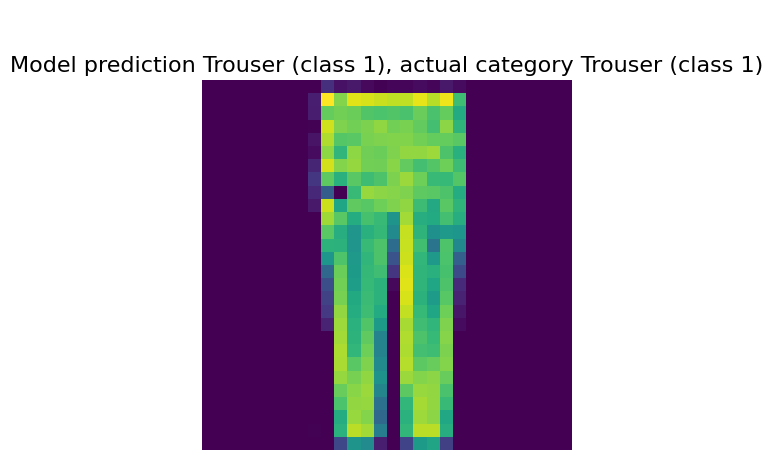

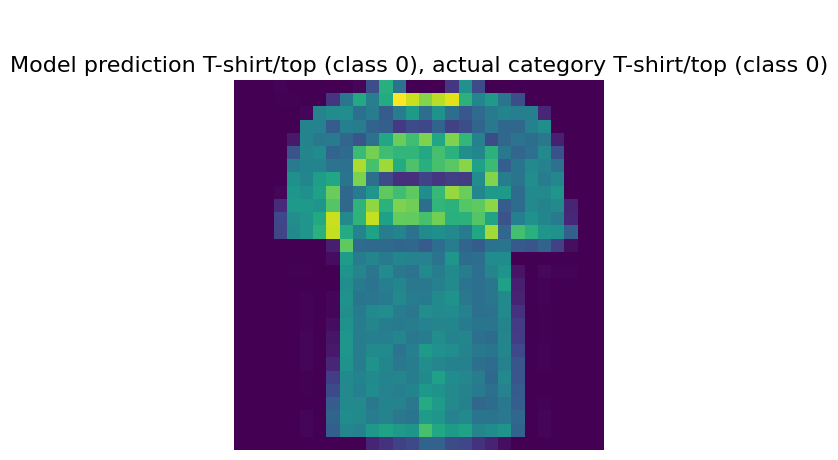

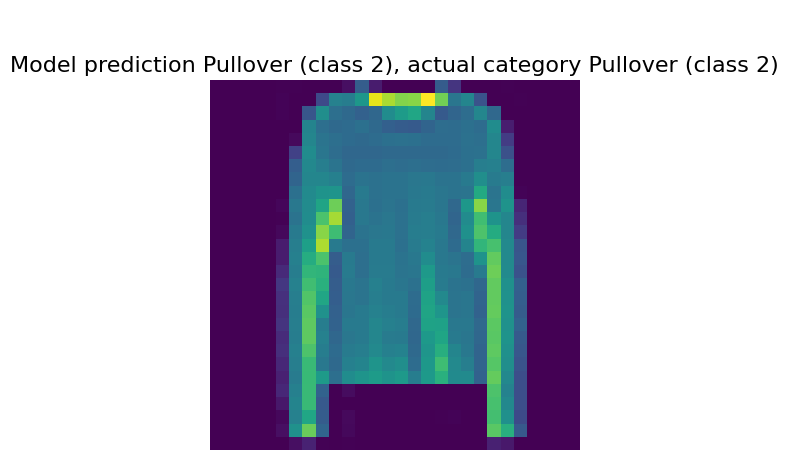

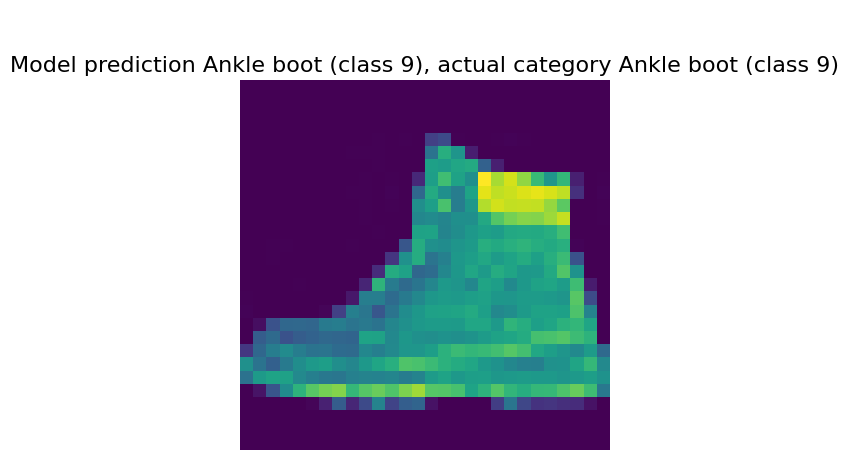

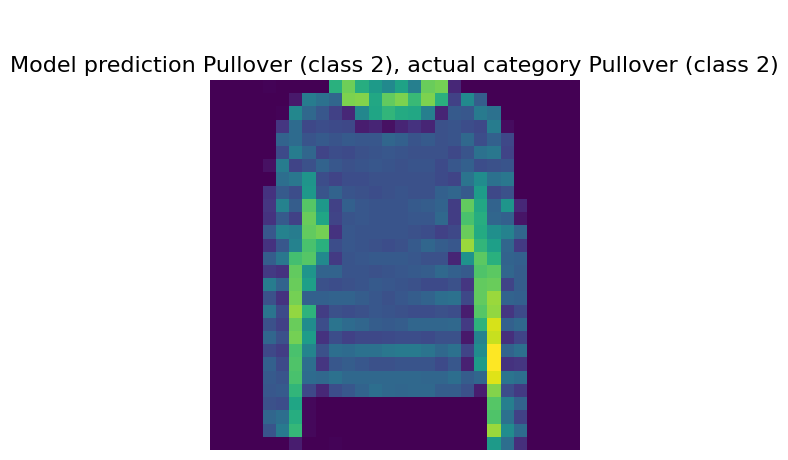

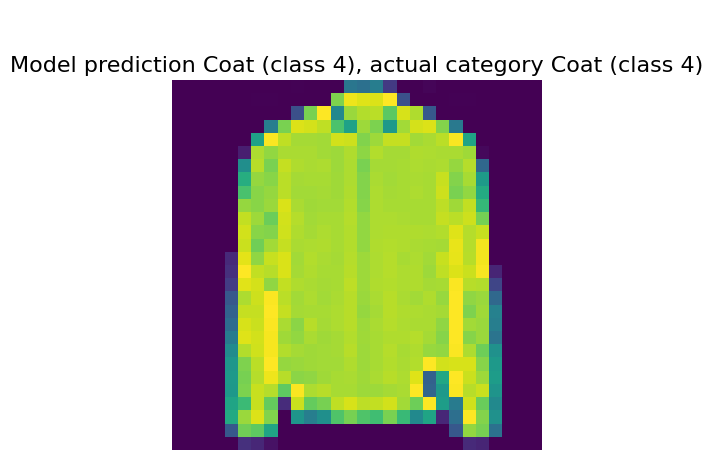

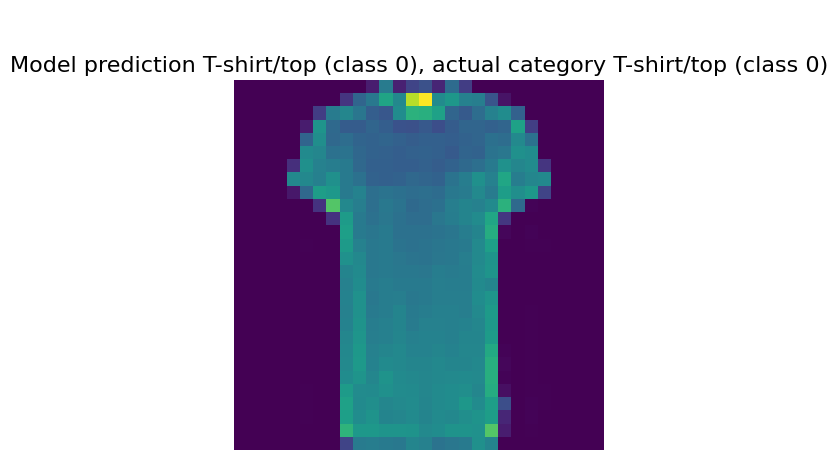

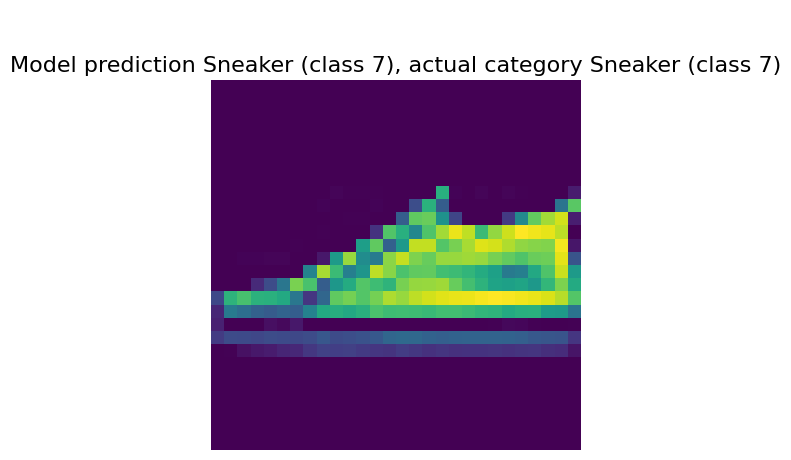

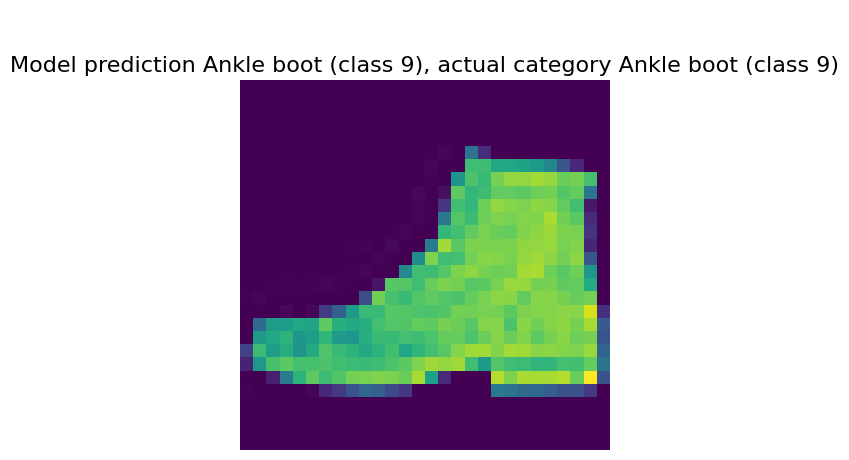

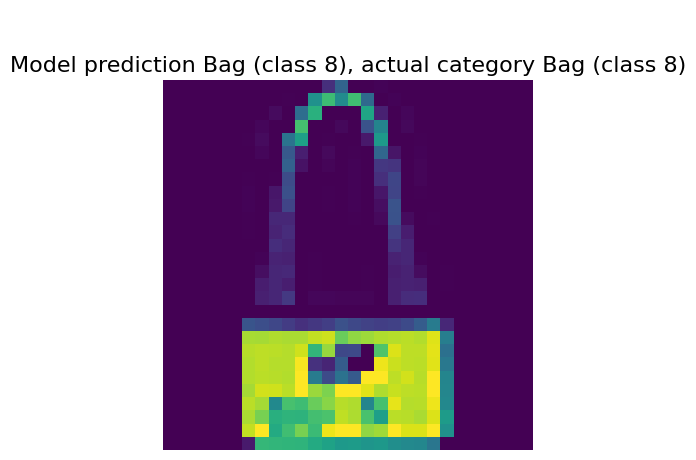

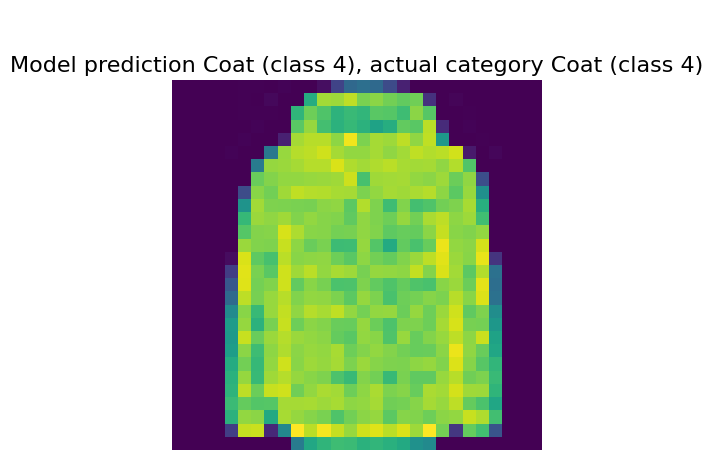

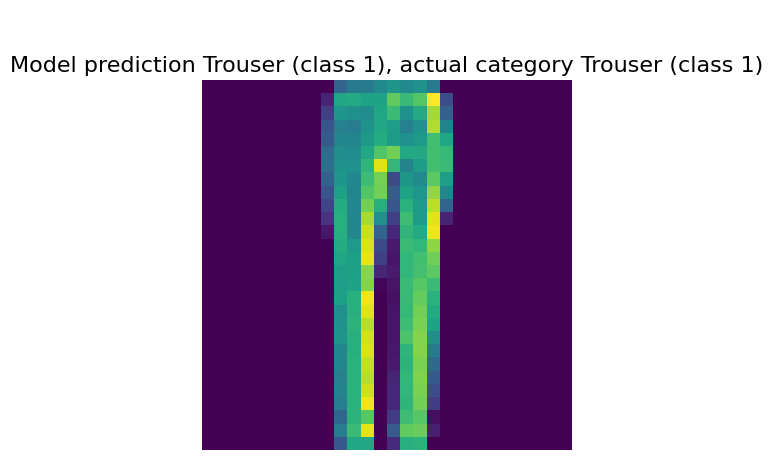

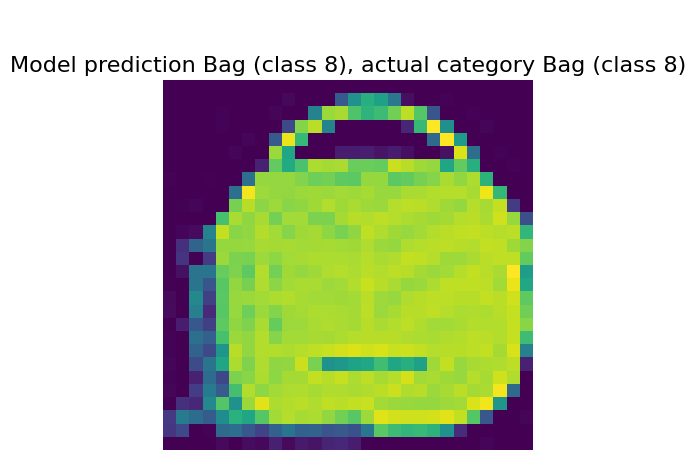

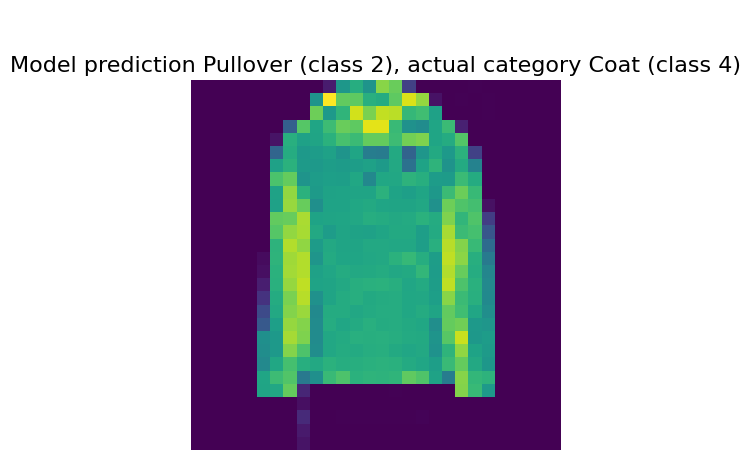

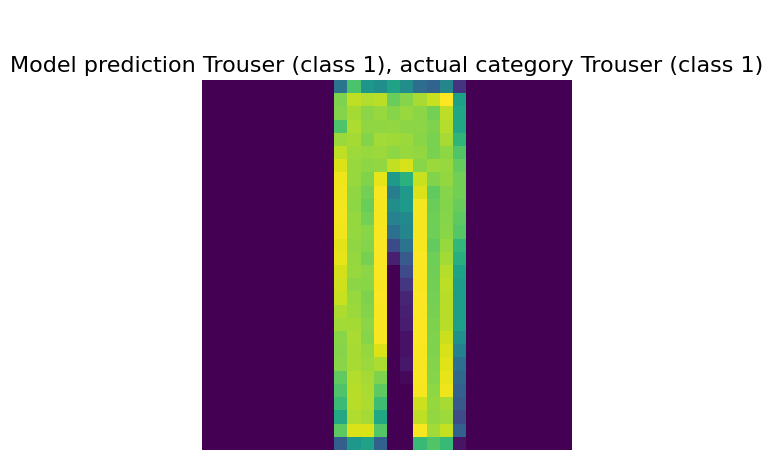

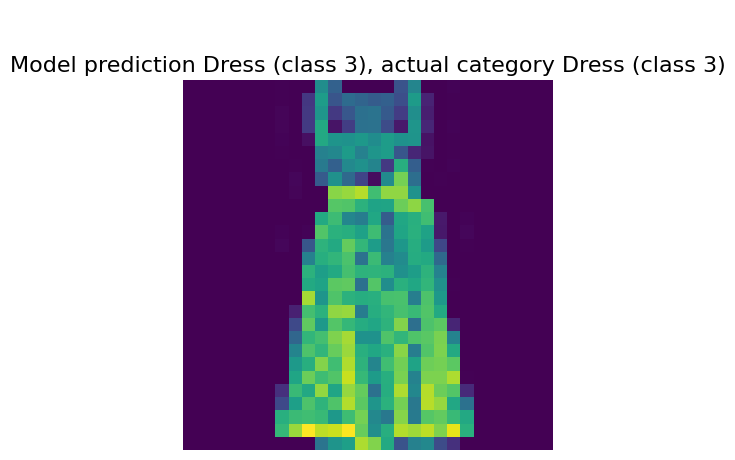

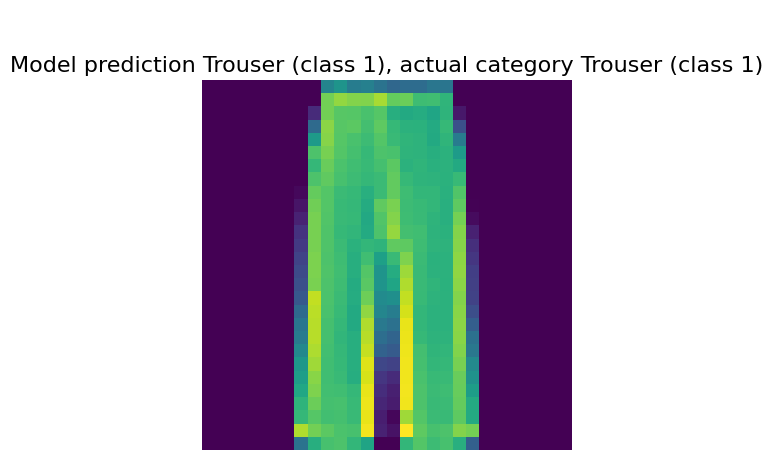

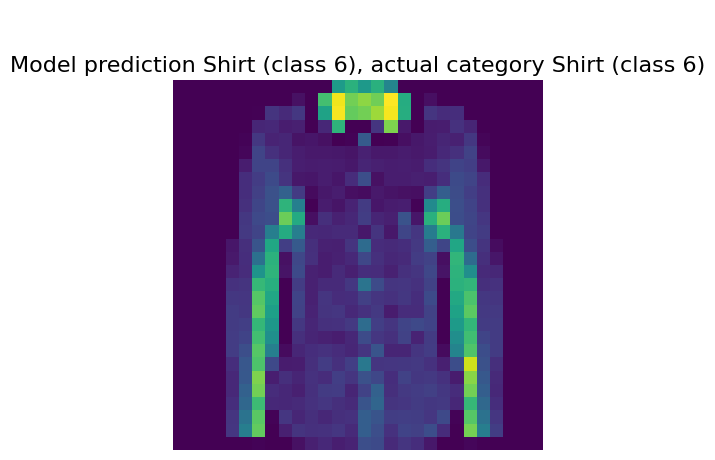

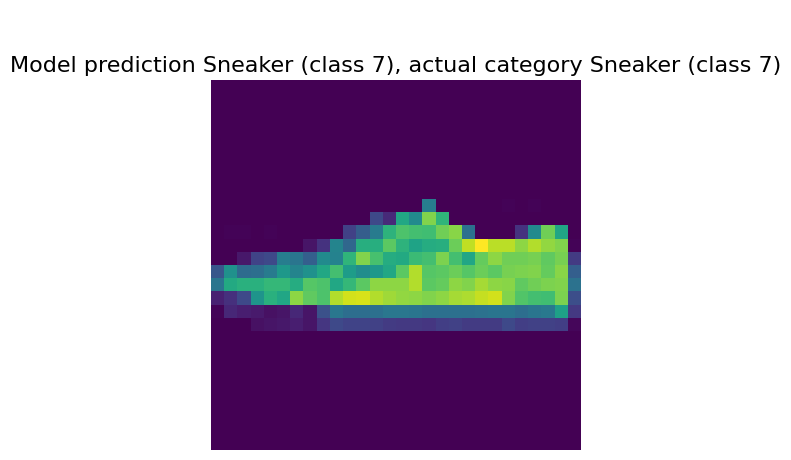

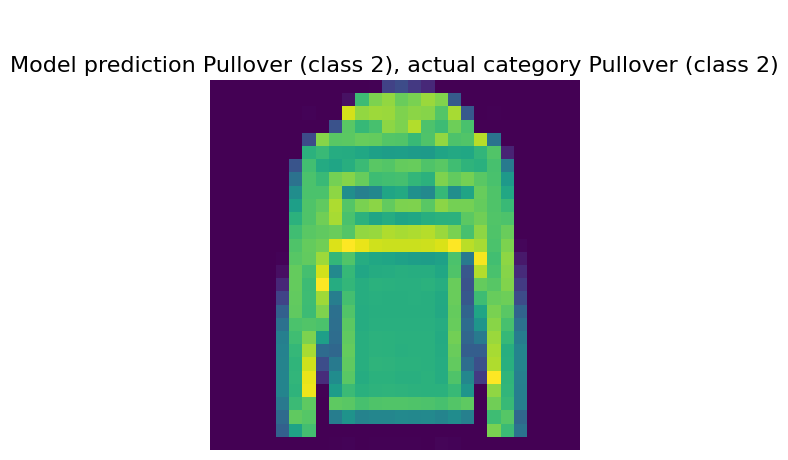

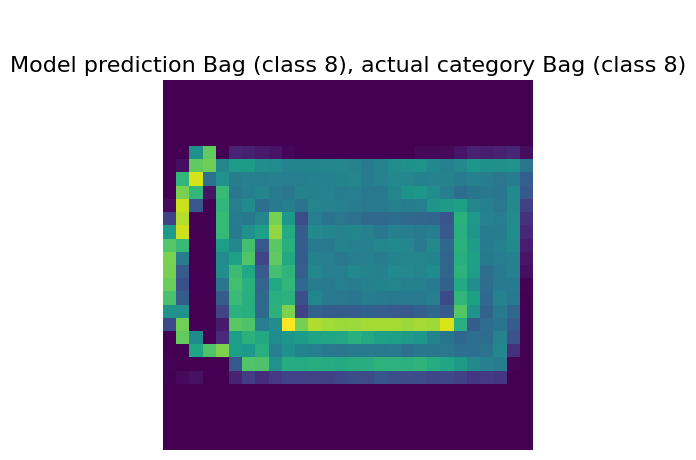

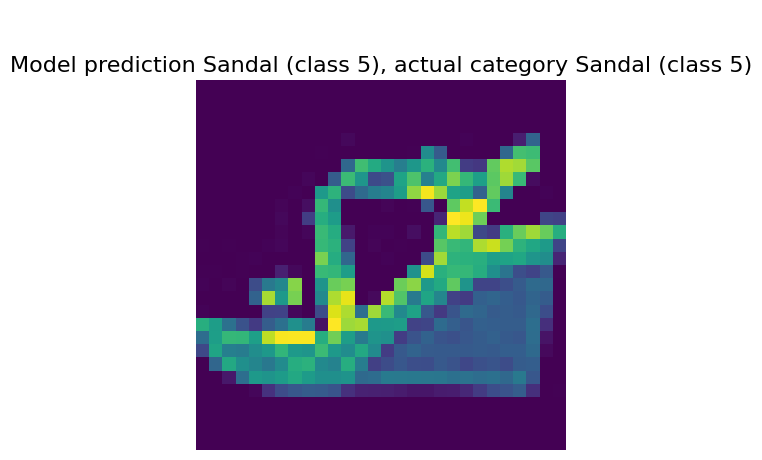

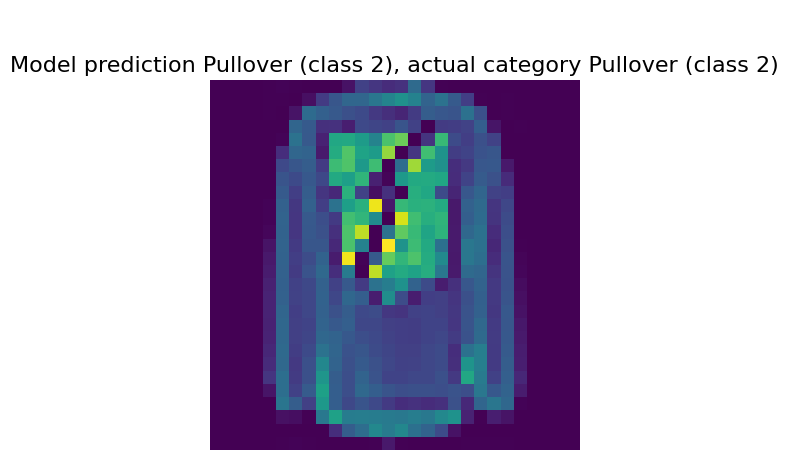

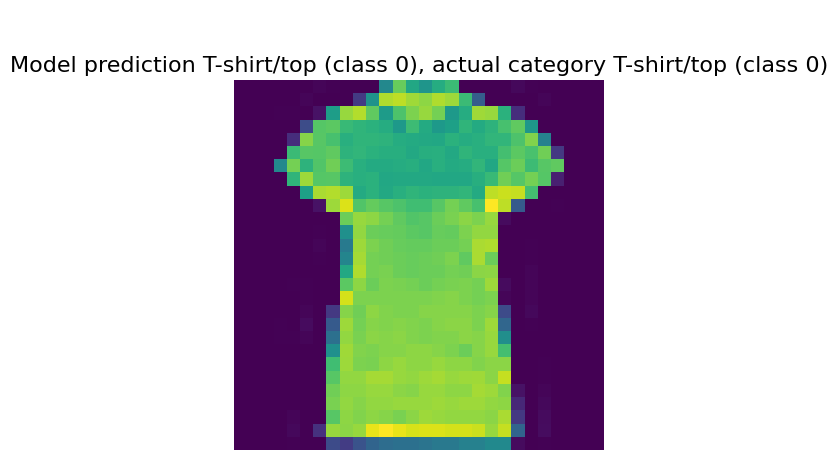

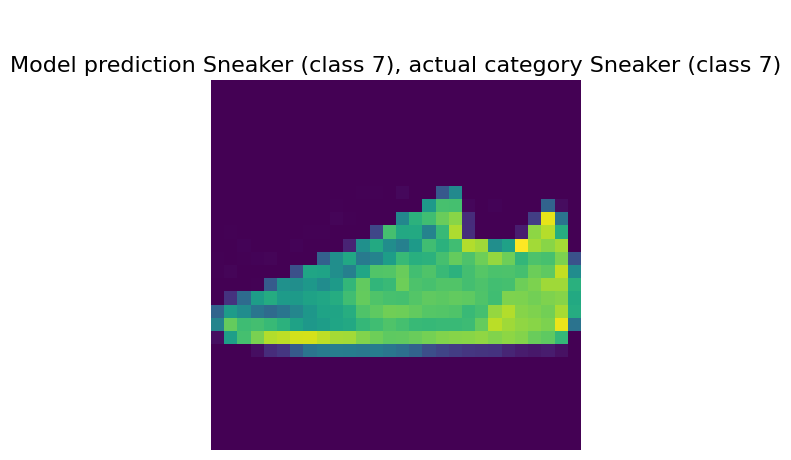

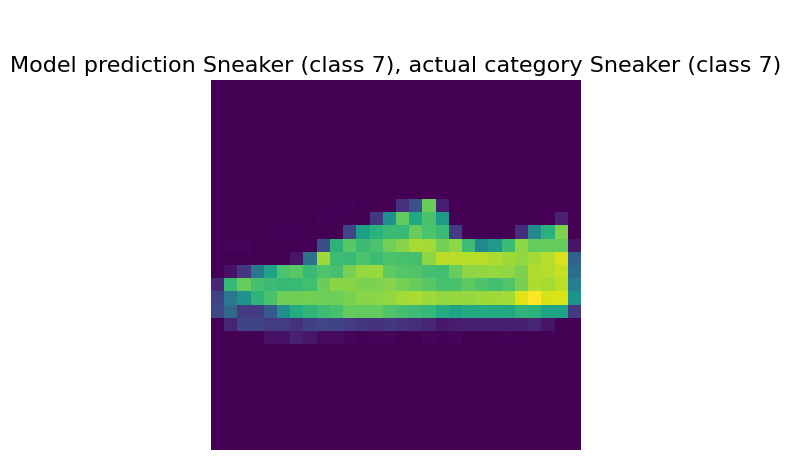

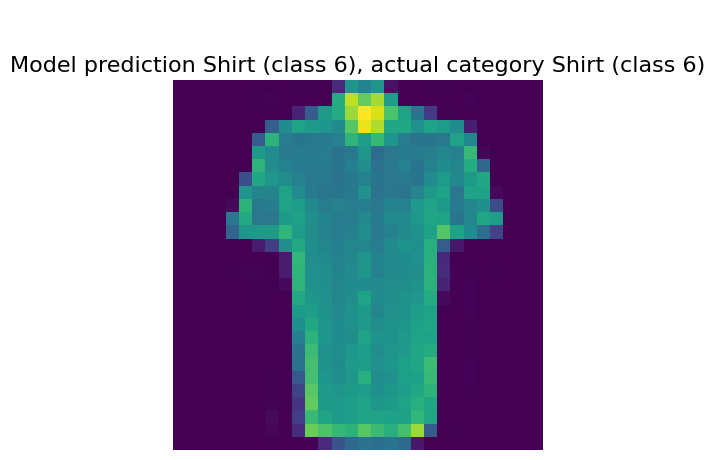

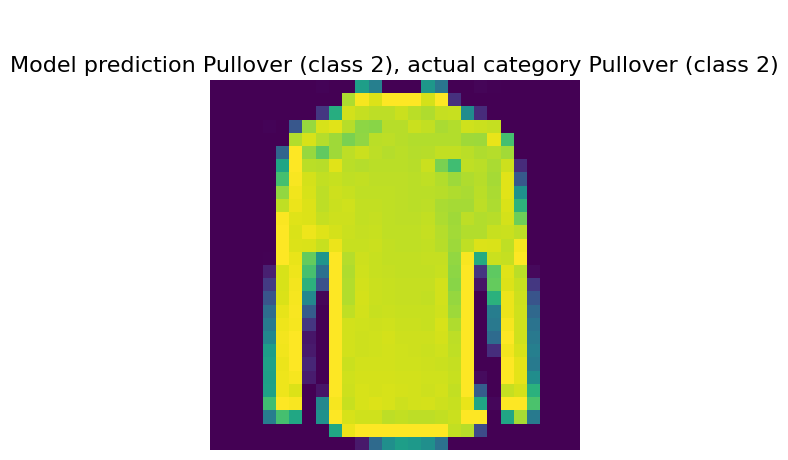

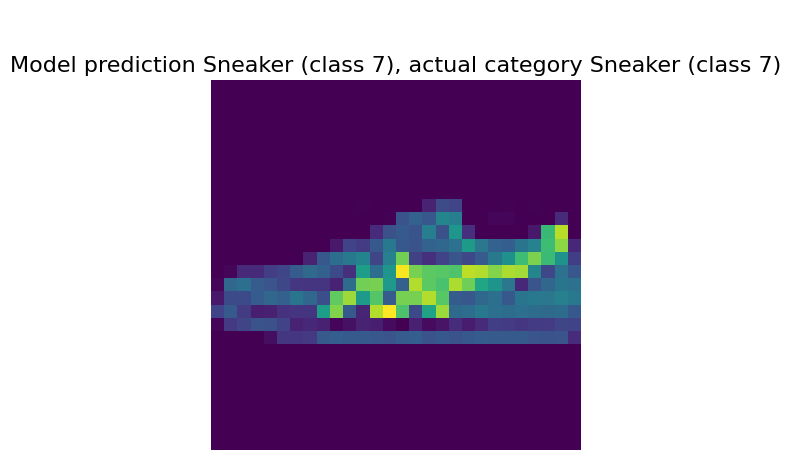

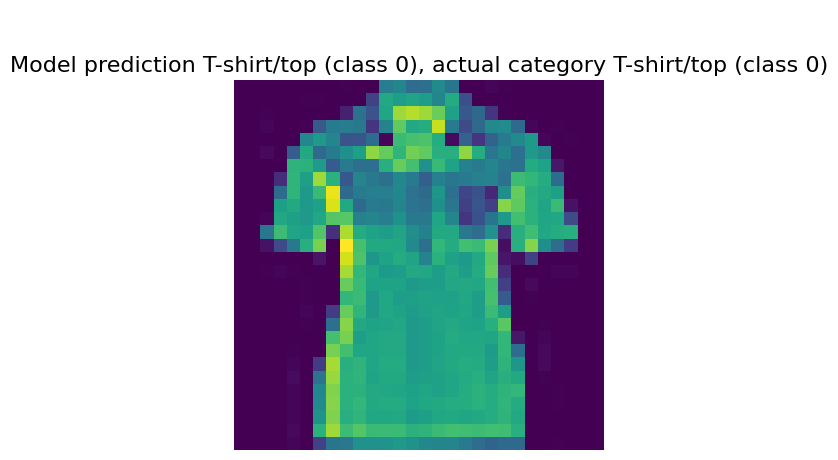

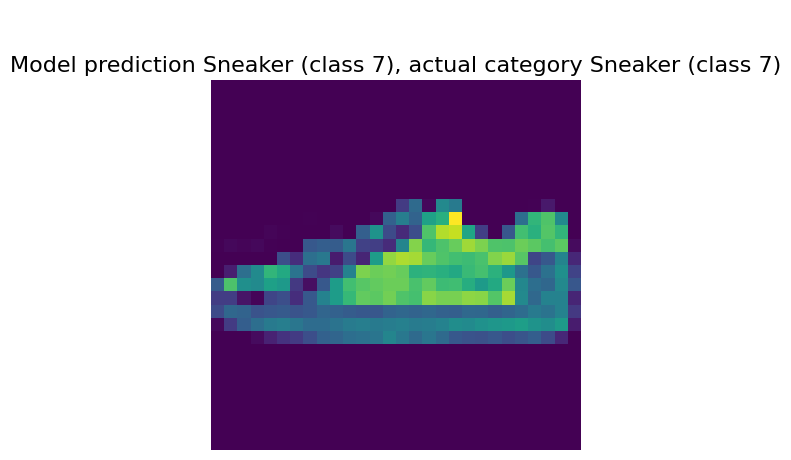

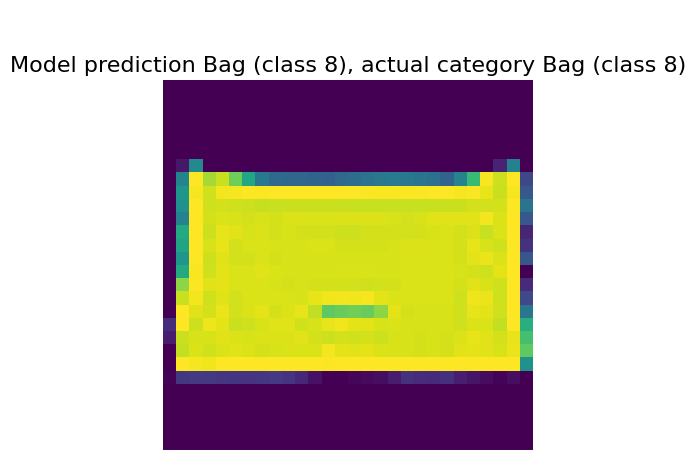

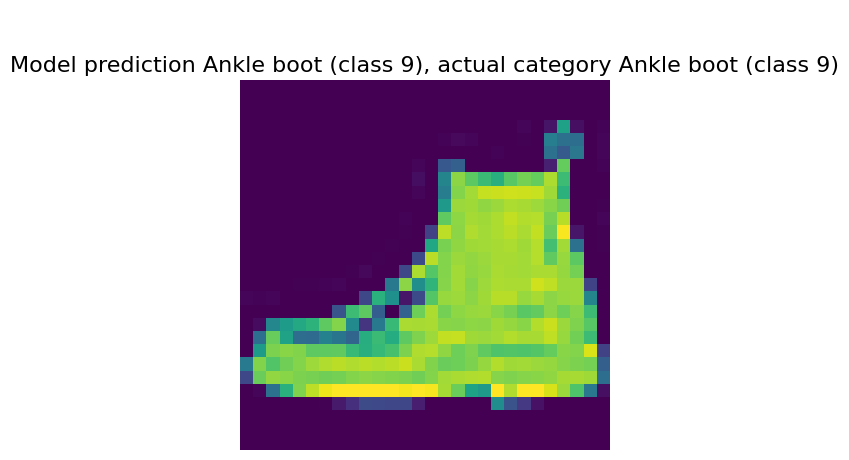

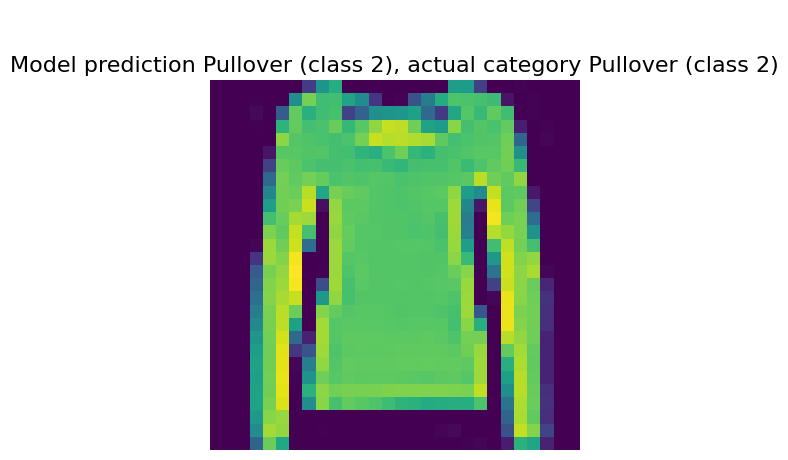

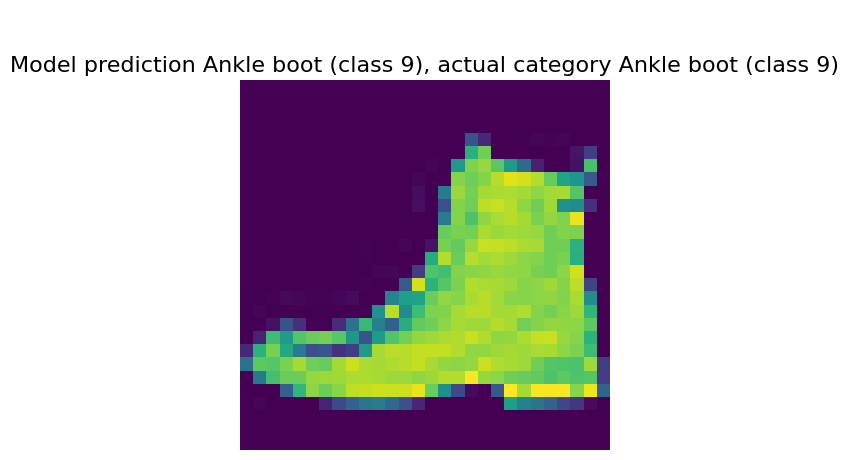

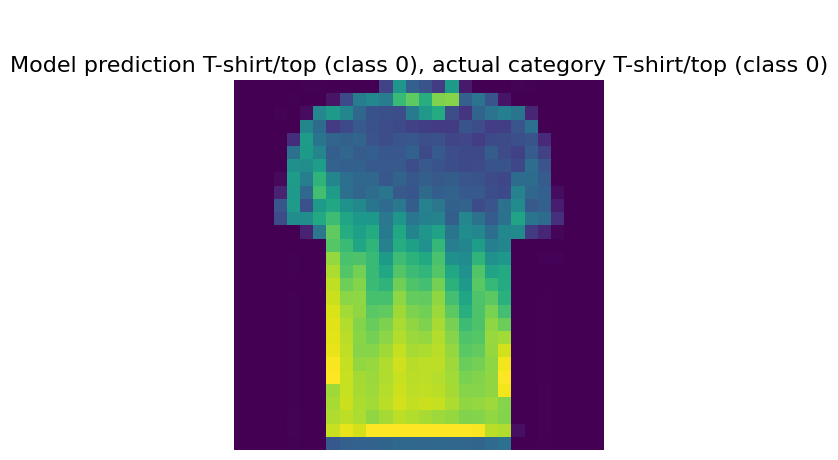

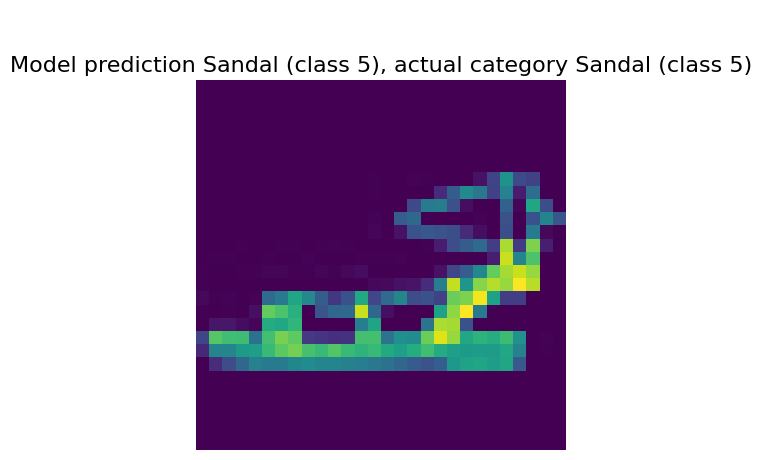

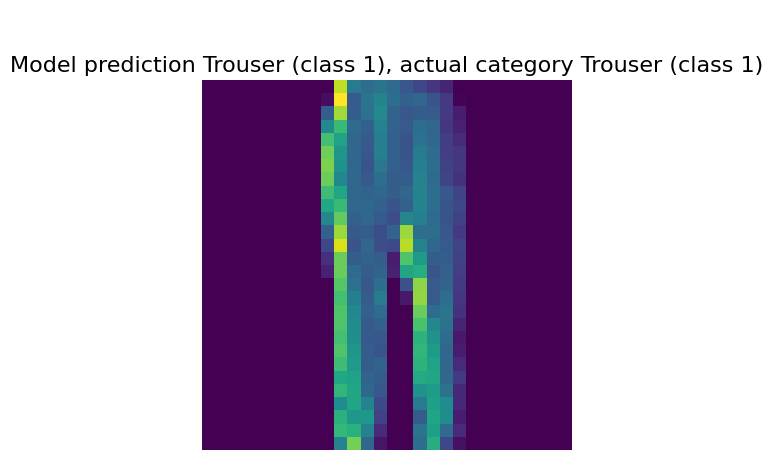

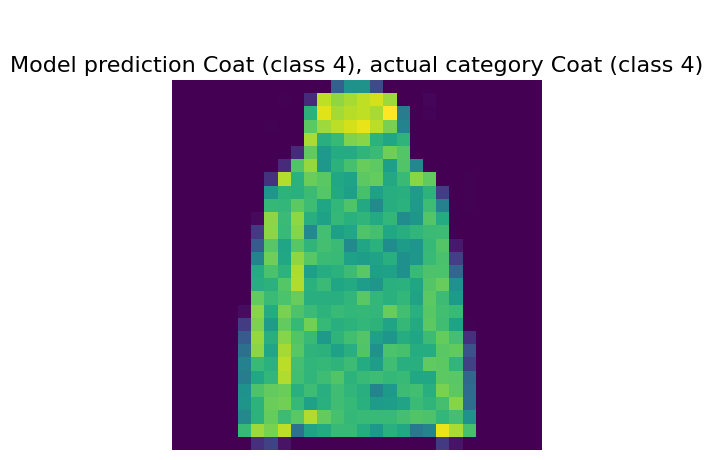

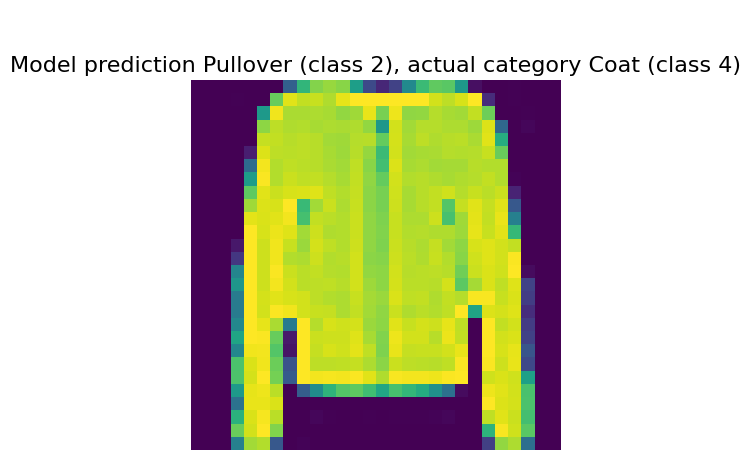

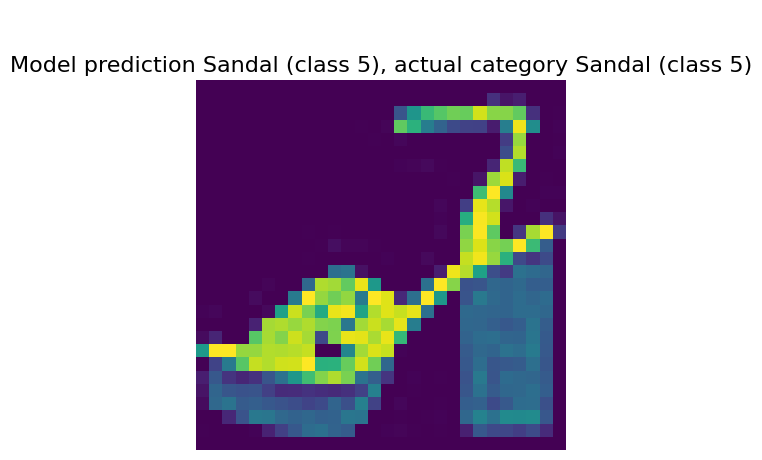

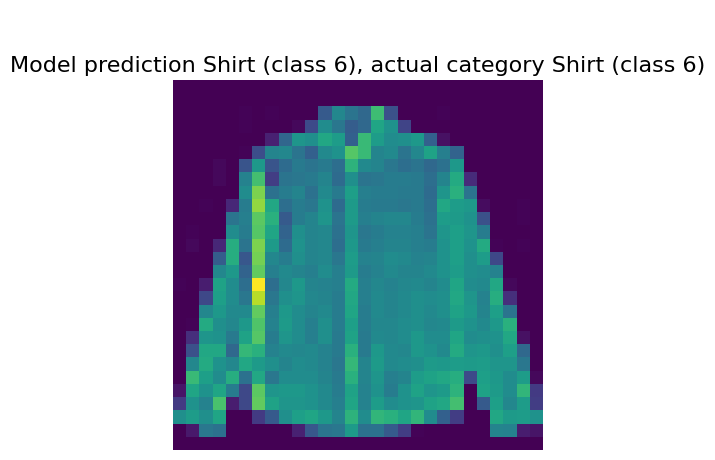

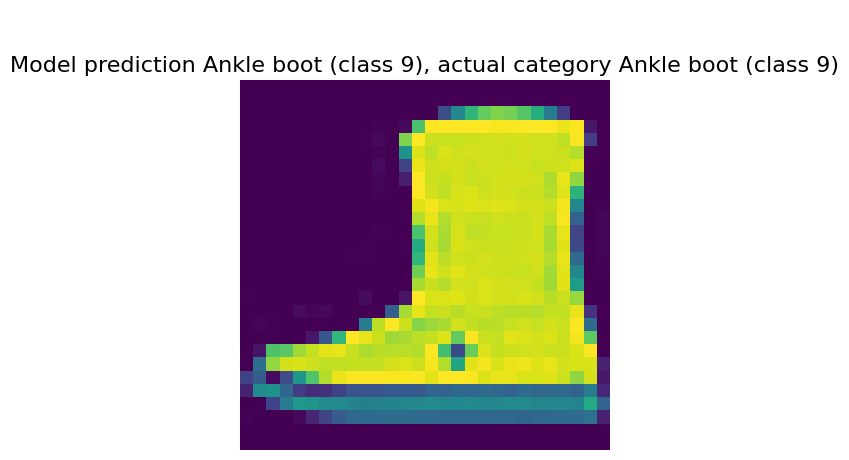

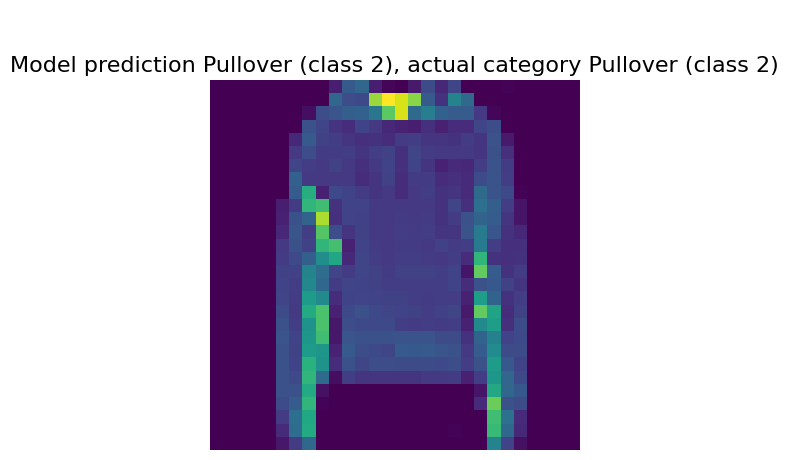

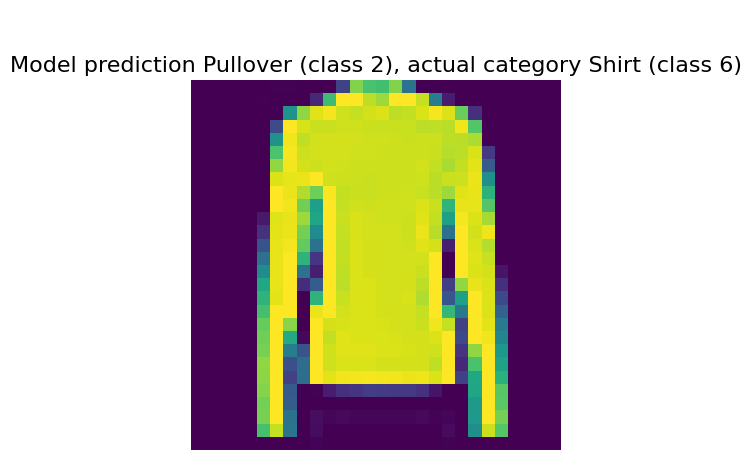

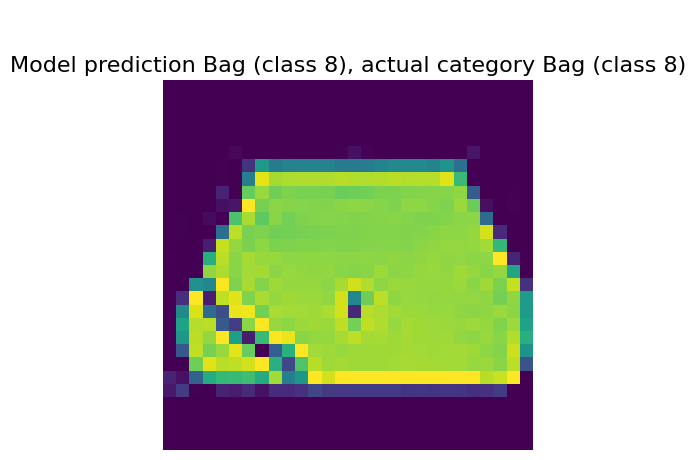

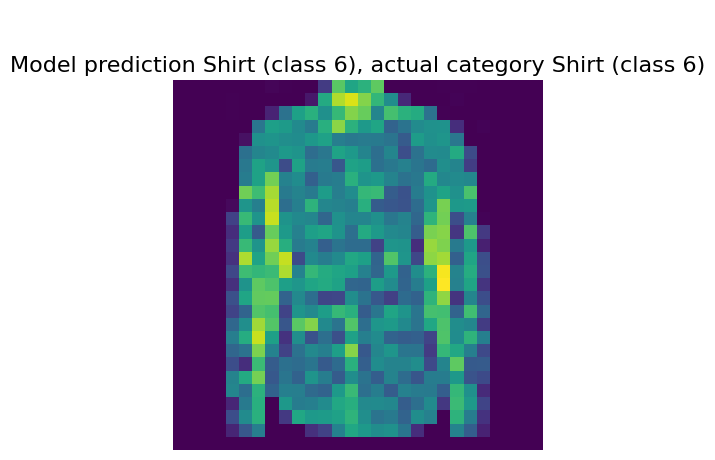

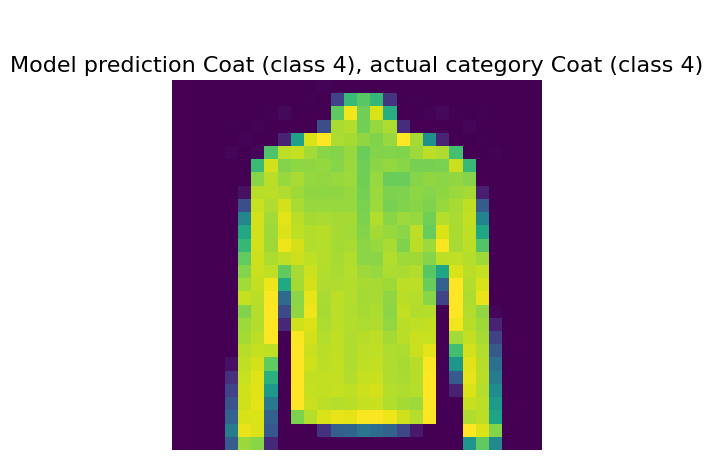

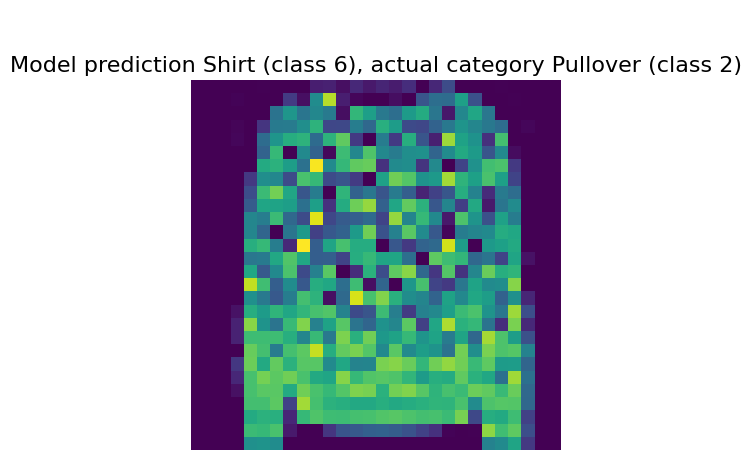

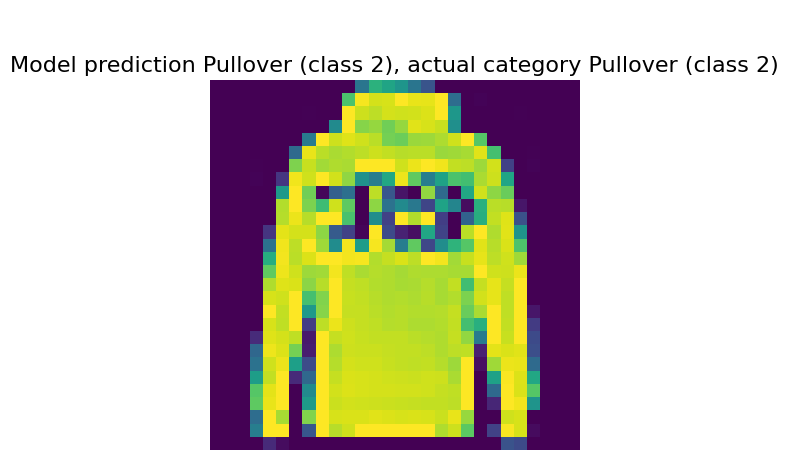

In [36]:
for i in range(200, 250):
    
    predicted_class = np.argmax(predictions[i])
    actual_class = test_labels[i]
                                
    show(i, 'Model prediction {} (class {}), actual category {} (class {})'.format(
          class_names[predicted_class], predicted_class,
          class_names[actual_class], actual_class
    ))

- go to the MLflow UI
- select the run and "Register model"
- Choose create new model and specify the name of the model
- Register the model
- Add tags and alias


In [37]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
# move model version to production
client.transition_model_version_stage(
  name = "fashion_nmist_model",
  version = 1,
  stage = 'Production',
)
## model is now ready for deployment

/var/folders/mk/9dr18q3j66b6915fh7r119pm0000gn/T/ipykernel_80562/3149898305.py:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1746207921784, current_stage='Production', description='', last_updated_timestamp=1746460619378, name='fashion_nmist_model', run_id='fe40abbb1d194e54838a00ec67eb1d41', run_link='', source='mlflow-artifacts:/166899072681846980/fe40abbb1d194e54838a00ec67eb1d41/artifacts/fashion_mnist_cnn', status='READY', status_message=None, tags={}, user_id='', version='1'>

In [38]:
# get the run id of the registered model
tf_run.info.run_id

'28551bc29d3d47b3b22e258a210b4afd'

## Serving models locally

Run the following command in the local virtual env path 
`mlflow models serve -m runs:/<run_id>/fashion_mnist_cnn --env-manager local --host 127.0.0.1:1234` or the absolute path to the model local artifacts 
`mlflow models serve -m /mlruns/28551bc29d3d47b3b22e258a210b4afd/artifacts/fashion_mnist_cnn --env-manager local --host 127.0.0.1 --port 1234`

- come back to the notebook to get predictions

Input data for prediction is obtained

In [39]:
X_test[7].shape

(28, 28, 1)

In [40]:
# the shape above does not include the batch size so expand the dimension
np.expand_dims(X_test[7], axis = 0).shape

(1, 28, 28, 1)

In [41]:
import json

# Get the tensor in the shape [-1, 28, 28, 1] and create a list of these tensors
# expand_dims adds an extra empty dimension at index 0 
# converting [28, 28, 1] -> [-1, 28, 28, 1]
data = json.dumps({"instances": np.expand_dims(X_test[7], axis = 0).tolist()})

data

'{"instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.00784313725490196], [0.011764705882352941], [0.0], [0.0], [0.3686274509803922], [0.592156862745098], [0.6078431372549019], [0.5411764705882353], [0.3843137254901961], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.1803921568627451], [1.0], [0.7725490196078432], [0.7686274509803922], [0.7490196078431373], [0.984313725490196], [0.011764705882352941], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.1568627450980392], [0.24705882352941178], [0.1607843137254902], [0.21176470588235294], [0.7176470588235294], [0.7725490196078432], [0.7098039215686275], [0.37254901960784315], [0.2549019607843137], [0.49019607843137253], [0.023529411764705882], [0.0], [0.0], [0.0], [0.0], [

In [44]:
# copy the output above and paste
!curl http://127.0.0.1:1234/invocations -H 'Content-Type: application/json' \
        -d '{"instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.00784313725490196], [0.011764705882352941], [0.0], [0.0], [0.3686274509803922], [0.592156862745098], [0.6078431372549019], [0.5411764705882353], [0.3843137254901961], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.1803921568627451], [1.0], [0.7725490196078432], [0.7686274509803922], [0.7490196078431373], [0.984313725490196], [0.011764705882352941], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.1568627450980392], [0.24705882352941178], [0.1607843137254902], [0.21176470588235294], [0.7176470588235294], [0.7725490196078432], [0.7098039215686275], [0.37254901960784315], [0.2549019607843137], [0.49019607843137253], [0.023529411764705882], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.2], [0.5137254901960784], [0.611764705882353], [0.3843137254901961], [0.30980392156862746], [0.23921568627450981], [0.5647058823529412], [0.6509803921568628], [0.611764705882353], [0.18823529411764706], [0.21176470588235294], [0.43529411764705883], [0.48627450980392156], [0.23921568627450981], [0.0784313725490196], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.5372549019607843], [0.27450980392156865], [0.43529411764705883], [0.3568627450980392], [0.18823529411764706], [0.3137254901960784], [0.6039215686274509], [0.403921568627451], [0.41568627450980394], [0.44313725490196076], [0.49411764705882355], [0.21568627450980393], [0.27450980392156865], [0.49411764705882355], [0.5058823529411764], [0.4588235294117647], [0.1450980392156863], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.17647058823529413], [0.8431372549019608], [0.0], [0.14901960784313725], [0.13333333333333333], [0.0], [0.06274509803921569], [0.3803921568627451], [0.0], [0.13333333333333333], [0.16862745098039217], [0.3568627450980392], [0.0], [0.0392156862745098], [0.17254901960784313], [0.06666666666666667], [0.2549019607843137], [0.592156862745098], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.3764705882352941], [0.12156862745098039], [0.3843137254901961], [0.6941176470588235], [0.615686274509804], [0.4588235294117647], [0.611764705882353], [0.9176470588235294], [0.43529411764705883], [0.5607843137254902], [0.6470588235294118], [0.796078431372549], [0.27058823529411763], [0.4196078431372549], [0.5568627450980392], [0.4823529411764706], [0.3215686274509804], [0.2980392156862745], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.6352941176470588], [0.24705882352941178], [0.19607843137254902], [0.3254901960784314], [0.2784313725490196], [0.10588235294117647], [0.22745098039215686], [0.5176470588235295], [0.17647058823529413], [0.3137254901960784], [0.3333333333333333], [0.5098039215686274], [0.19215686274509805], [0.3607843137254902], [0.4666666666666667], [0.4823529411764706], [0.3215686274509804], [0.40784313725490196], [0.0784313725490196], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.6901960784313725], [0.3607843137254902], [0.1568627450980392], [0.22745098039215686], [0.25882352941176473], [0.043137254901960784], [0.16862745098039217], [0.4980392156862745], [0.03137254901960784], [0.23137254901960785], [0.19607843137254902], [0.4823529411764706], [0.24313725490196078], [0.29411764705882354], [0.32941176470588235], [0.08235294117647059], [0.40784313725490196], [0.5490196078431373], [0.15294117647058825], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.6274509803921569], [0.42745098039215684], [0.4470588235294118], [0.36470588235294116], [0.4], [0.16470588235294117], [0.2980392156862745], [0.6235294117647059], [0.1568627450980392], [0.39215686274509803], [0.3215686274509804], [0.615686274509804], [0.09411764705882353], [0.19607843137254902], [0.3843137254901961], [0.32941176470588235], [0.6352941176470588], [0.596078431372549], [0.1803921568627451], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.42745098039215684], [0.054901960784313725], [0.2823529411764706], [0.41568627450980394], [0.48627450980392156], [0.2627450980392157], [0.36470588235294116], [0.6705882352941176], [0.2196078431372549], [0.44313725490196076], [0.403921568627451], [0.6941176470588235], [0.20392156862745098], [0.34901960784313724], [0.4235294117647059], [0.4627450980392157], [0.43137254901960786], [0.3686274509803922], [0.10980392156862745], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.17647058823529413], [0.7725490196078432], [0.0784313725490196], [0.2901960784313726], [0.43137254901960786], [0.42745098039215684], [0.21568627450980393], [0.3058823529411765], [0.6941176470588235], [0.24313725490196078], [0.4627450980392157], [0.403921568627451], [0.6196078431372549], [0.1450980392156863], [0.3333333333333333], [0.41568627450980394], [0.4392156862745098], [0.14901960784313725], [0.24313725490196078], [0.36470588235294116], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.2196078431372549], [0.8666666666666667], [0.4549019607843137], [0.7450980392156863], [0.24705882352941178], [0.09803921568627451], [0.00784313725490196], [0.027450980392156862], [0.4117647058823529], [0.0196078431372549], [0.23137254901960785], [0.14901960784313725], [0.3333333333333333], [0.0], [0.058823529411764705], [0.12549019607843137], [0.8117647058823529], [0.6], [0.7843137254901961], [0.5843137254901961], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.054901960784313725], [0.3411764705882353], [0.06666666666666667], [0.37254901960784315], [0.5725490196078431], [0.5137254901960784], [0.403921568627451], [0.396078431372549], [0.7647058823529411], [0.2784313725490196], [0.41568627450980394], [0.5137254901960784], [0.7529411764705882], [0.26666666666666666], [0.3803921568627451], [0.43137254901960786], [0.807843137254902], [0.30980392156862746], [0.34509803921568627], [0.1803921568627451], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.2], [0.49019607843137253], [0.32941176470588235], [0.4588235294117647], [0.5843137254901961], [0.5254901960784314], [0.4392156862745098], [0.42745098039215684], [0.8784313725490196], [0.4470588235294118], [0.6039215686274509], [0.6313725490196078], [0.7568627450980392], [0.28627450980392155], [0.4980392156862745], [0.5686274509803921], [0.6431372549019608], [0.2196078431372549], [0.36470588235294116], [0.3607843137254902], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.34509803921568627], [0.4588235294117647], [0.34901960784313724], [0.796078431372549], [0.2627450980392157], [0.09411764705882353], [0.03137254901960784], [0.0392156862745098], [0.38823529411764707], [0.03529411764705882], [0.22745098039215686], [0.19607843137254902], [0.3254901960784314], [0.0], [0.06274509803921569], [0.13333333333333333], [0.6941176470588235], [0.4117647058823529], [0.45098039215686275], [0.43137254901960786], [0.06274509803921569], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.5450980392156862], [0.4745098039215686], [0.4235294117647059], [0.9490196078431372], [0.24705882352941178], [0.35294117647058826], [0.2], [0.24705882352941178], [0.6352941176470588], [0.19607843137254902], [0.3764705882352941], [0.4392156862745098], [0.5137254901960784], [0.08235294117647059], [0.3058823529411765], [0.2823529411764706], [0.5764705882352941], [0.6039215686274509], [0.4980392156862745], [0.5764705882352941], [0.1450980392156863], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.3215686274509804], [0.10196078431372549], [0.27450980392156865], [0.7137254901960784], [0.1803921568627451], [0.4196078431372549], [0.2235294117647059], [0.2549019607843137], [0.6392156862745098], [0.20784313725490197], [0.33725490196078434], [0.4588235294117647], [0.5215686274509804], [0.09803921568627451], [0.3254901960784314], [0.2823529411764706], [0.5294117647058824], [0.6313725490196078], [0.3215686274509804], [0.37254901960784315], [0.058823529411764705], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.5098039215686274], [0.1803921568627451], [0.4627450980392157], [0.6078431372549019], [0.2784313725490196], [0.5294117647058824], [0.3254901960784314], [0.3764705882352941], [0.7568627450980392], [0.3176470588235294], [0.4666666666666667], [0.5764705882352941], [0.611764705882353], [0.18823529411764706], [0.44313725490196076], [0.3686274509803922], [0.3803921568627451], [0.5490196078431373], [0.21176470588235294], [0.3333333333333333], [0.12549019607843137], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.803921568627451], [0.5137254901960784], [0.9490196078431372], [0.6705882352941176], [0.0784313725490196], [0.27058823529411763], [0.07450980392156863], [0.18823529411764706], [0.5450980392156862], [0.14901960784313725], [0.3254901960784314], [0.40784313725490196], [0.4235294117647059], [0.00392156862745098], [0.25882352941176473], [0.19215686274509805], [0.27450980392156865], [0.9372549019607843], [0.7058823529411765], [0.807843137254902], [0.3333333333333333], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.25882352941176473], [0.03529411764705882], [0.5607843137254902], [0.4235294117647059], [0.1411764705882353], [0.2901960784313726], [0.043137254901960784], [0.12549019607843137], [0.45098039215686275], [0.043137254901960784], [0.1568627450980392], [0.25882352941176473], [0.3137254901960784], [0.0], [0.1450980392156863], [0.17647058823529413], [0.2980392156862745], [0.5450980392156862], [0.30980392156862746], [0.3176470588235294], [0.08235294117647059], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.39215686274509803], [0.22745098039215686], [0.5725490196078431], [0.27058823529411763], [0.403921568627451], [0.7254901960784313], [0.48627450980392156], [0.5882352941176471], [0.9607843137254902], [0.5176470588235295], [0.6313725490196078], [0.792156862745098], [0.8235294117647058], [0.41568627450980394], [0.6039215686274509], [0.6745098039215687], [0.403921568627451], [0.6274509803921569], [0.4], [0.4235294117647059], [0.1450980392156863], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.43529411764705883], [0.30980392156862746], [0.6549019607843137], [0.06666666666666667], [0.07450980392156863], [0.25882352941176473], [0.023529411764705882], [0.20784313725490197], [0.5529411764705883], [0.17254901960784313], [0.3411764705882353], [0.43529411764705883], [0.4470588235294118], [0.06274509803921569], [0.21176470588235294], [0.2823529411764706], [0.0], [0.5725490196078431], [0.4470588235294118], [0.49019607843137253], [0.1803921568627451], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.48627450980392156], [0.4196078431372549], [0.796078431372549], [0.027450980392156862], [0.3058823529411765], [0.3176470588235294], [0.0392156862745098], [0.30196078431372547], [0.39215686274509803], [0.16862745098039217], [0.30196078431372547], [0.25882352941176473], [0.39215686274509803], [0.0], [0.12549019607843137], [0.30196078431372547], [0.09803921568627451], [0.5215686274509804], [0.5647058823529412], [0.611764705882353], [0.21176470588235294], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.30980392156862746], [0.09019607843137255], [0.5725490196078431], [0.00784313725490196], [0.3568627450980392], [0.33725490196078434], [0.09803921568627451], [0.5215686274509804], [0.4470588235294118], [0.4392156862745098], [0.4823529411764706], [0.35294117647058826], [0.6078431372549019], [0.12156862745098039], [0.23921568627450981], [0.42745098039215684], [0.15294117647058825], [0.2784313725490196], [0.44313725490196076], [0.38823529411764707], [0.07450980392156863], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.19215686274509805], [0.35294117647058826], [0.6901960784313725], [0.0], [0.5411764705882353], [0.4392156862745098], [0.13725490196078433], [0.6509803921568628], [0.4549019607843137], [0.4470588235294118], [0.5019607843137255], [0.38823529411764707], [0.6431372549019608], [0.17254901960784313], [0.2784313725490196], [0.5411764705882353], [0.1568627450980392], [0.25098039215686274], [0.5333333333333333], [0.33725490196078434], [0.00784313725490196], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.01568627450980392], [0.6196078431372549], [0.8980392156862745], [0.0], [0.17254901960784313], [0.39215686274509803], [0.12549019607843137], [0.6980392156862745], [0.3803921568627451], [0.5176470588235295], [0.4980392156862745], [0.42745098039215684], [0.6823529411764706], [0.16470588235294117], [0.30196078431372547], [0.4745098039215686], [0.0], [0.33725490196078434], [0.7098039215686275], [0.40784313725490196], [0.00392156862745098], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.2980392156862745], [0.5215686274509804], [0.0], [0.0], [0.0], [0.0], [0.3137254901960784], [0.11372549019607843], [0.4], [0.29411764705882354], [0.16862745098039217], [0.32941176470588235], [0.0], [0.0392156862745098], [0.0], [0.0], [0.13725490196078433], [0.32941176470588235], [0.21568627450980393], [0.0], [0.0], [0.0], [0.0]]]]}'

{"predictions": [[0.00012721665552817285, 2.4638010742705774e-08, 0.00737772835418582, 0.0005000344244763255, 0.0460757240653038, 2.038832880302266e-09, 0.9456843733787537, 6.750984771208834e-10, 0.00023495008645113558, 1.3168415247122311e-09]]}

### TODO Recording:

- Copy over the prediction output and paste it down below in the string

In [45]:
predictions = json.loads(
    '{"predictions": [[1.3674216461367905e-05, 7.548281928393408e-07, 0.0013629697496071458, 2.8896722596982727e-06, 0.22779369354248047, 4.987456847516114e-08, 0.7708002328872681, 1.3917071661762037e-10, 2.5744931917870417e-05, 4.4181444280866344e-08]]}'
)['predictions'][0]

predictions

[1.3674216461367905e-05,
 7.548281928393408e-07,
 0.0013629697496071458,
 2.8896722596982727e-06,
 0.22779369354248047,
 4.987456847516114e-08,
 0.7708002328872681,
 1.3917071661762037e-10,
 2.5744931917870417e-05,
 4.4181444280866344e-08]

In [46]:
class_names[np.argmax(predictions)]

'Shirt'

### Will use AWS Sagemaker for Deployment